MIT License

Copyright (c) 2024 Justin Randall, Smart Interactive Transformations Inc.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# Overview

The main purpose of this notebook is as a helpful companion/tool for [a blog post](https://sitinc.net/2023/12/23/the-last-sectional-of-the-year/) by Smart Interactive Transformations Inc. around identifying emerging contact drivers through conversational data.  The notebook builds on some of the output from the [getting started notebook](https://github.com/sitinc/journey-discovery-getting-started/blob/main/notes/journey-discovery-getting-started.ipynb), so make sure you step through it and generate the base data required to move forward with this notebook.

This notebook walks you through separating USER utterances from the generated transcripts from the [getting started notebook](https://github.com/sitinc/journey-discovery-getting-started/blob/main/notes/journey-discovery-getting-started.ipynb), then analyze clustering of utterances and extract common entities.  You can use this code to analyze real transcripts, but see my comments along the way to understand some things you might want to adjust or implement.  In most cases, I plan to implement these suggestions in the form of a feature behaviour at some point.

The first few sections of this notebook will extract similar and improved insights to what the [getting started notebook](https://github.com/sitinc/journey-discovery-getting-started/blob/main/notes/journey-discovery-getting-started.ipynb) covers.  We will then introduce new emergent contact driver transcripts, and re-run most of the steps to compare the final outputs between the two runs.

**Warning:**
The notebook uses the OpenAI chat completions API to generate example transcripts, and generate intent names for cluster groupings.  Please make sure to consult [OpenAI API Pricing](https://openai.com/pricing) to understand the costs associated with your executions.

I will add locally-run open source solutions for generating embeddings, generating transcripts, and naming clusters in the near future.

Once we get through the entire notebook, we'll have a sense of identifying USER contact drivers and some process for identifying emergent contact drivers as new product or process changes are introduced that alter the customer or team member experience.

All underlying Python code necessary to run the notebook is included within this project for simplicity, but you can also import the packaged interactovery Python module from PyPI directly into your projects if you wish to re-use any of its components:


```bash
pip install interactovery
```

## Setting up the environment

Before you can run all the code in this notebook, you will need to configure your OpenAI API key and ORG ID in a local environment file, conf/dev.env:

```conf/dev.env
OPENAI_API_KEY=<Your OpenAI API Key>
OPENAI_ORG=<Your OpenAI Org ID>
```

Below I am loading the 'en_core_web_lg' language model.  After installing Python dependencies, you will need to manually download this language model.

```bash
python -m spacy download en_core_web_lg
```

If you with to use a different language model, ensure to download the desired model, and update the reference in the below cell.

In [11]:
from interactovery.transcripts import Transcripts, Utterances
from interactovery.openaiwrap import OpenAiWrap
from interactovery.clusterwrap import ClusterWrap
from interactovery.vizwrap import VizWrap
from interactovery.workspaces import WorkspaceManager
from interactovery.utils import Utils

import spacy
import pandas as pd

from dotenv import load_dotenv
import os
from pathlib import Path

import logging.config

# Initialize the notebook environment.

# Key directories.
prj_root = os.path.join(os.getcwd(), '..')
conf_dir = os.path.join(prj_root, 'conf')
env_conf = os.path.join(conf_dir, 'dev.env')
workspace_root = os.path.join(prj_root, 'workspaces')

# Logger configuration.
logger_conf = os.path.join(conf_dir, 'logging.conf')
logger_name = 'notebookLogger'

logging.config.fileConfig(logger_conf)
log = logging.getLogger(logger_name)

# Environment variables.
env_path = Path(env_conf)
load_dotenv(dotenv_path=env_path)

# Initialize the OpenAI API Wrapper
openai_api_key = os.getenv('OPENAI_API_KEY')
openai_org = os.getenv('OPENAI_ORG')
openai_client = OpenAiWrap(
    openai_org,
    openai_api_key
)

# Initialize the spaCy language model
spacy_nlp = spacy.load('en_core_web_lg')

# Initialize the Transcript Processor
tss = Transcripts(
    openai=openai_client,
    spacy_nlp=spacy_nlp,
)

# Initialize the Clustering Client.
cluster_client: ClusterWrap = ClusterWrap(
    openai=openai_client,
    spacy_nlp=spacy_nlp,
)

wm = WorkspaceManager(root_dir=workspace_root)
workspace = wm.create(name='test1-user')
workspace_old = wm.create(name='test1')

# Analyzing the USER-only Transcript Utterances

You need to complete the [getting started notebook](https://github.com/sitinc/journey-discovery-getting-started/blob/main/notes/journey-discovery-getting-started.ipynb) before moving forward.  It will generate a workspace directory "test1" that contains a file will need to move forward.  Alternatively, you can also take your own data and fit it to a CSV with columns "source", "participant", and "utterance", copy it into the ../workspaces/test1-user/transcripts-combined/ folder with the name 'transcripts_combined.csv'.  The notebook stages go through some data prep, such as removing commas, and other steps.  If you produce your own CSV for this step, make sure it will parse successfully.  Alternatively, since we're working with Pandas data frames, fit any data you want into the data frame with columns "source", "participant", and "utterance", pre-processed to your hearts content. :)

## Copying the Transcripts Combined CSV File

Let's copy the 'transcripts-combined' directory over from the previous workspace.

In [3]:
Utils.copy_dir(
    src_dir=workspace_old.ts_combined_path,
    dst_dir=workspace.ts_combined_path,
)

# Analyzing USER-only Utterances from the Getting Started Notebook

The first few sections of this notebook will extract similar and improved insights from [getting started notebook](https://github.com/sitinc/journey-discovery-getting-started/blob/main/notes/journey-discovery-getting-started.ipynb).  We will then introduce new emergent contact driver transcripts and re-run most of the steps to compare the final outputs between the two runs.

## Loading the USER-only Utterances

Let's load the utterances.

In [2]:
df = Transcripts.get_combined_utterances(in_dir=workspace.ts_combined_path)
user_df = df[df['participant'] != 'AGENT']
utterances_list = user_df['utterance'].tolist()

utterance_csv_path = os.path.join(workspace.ts_combined_path, 'transcripts_combined.csv')

user_utterances = Utterances(
    source=utterance_csv_path,
    utterances=utterances_list,
)

print(f"user_utterances: {user_utterances}")

user_utterances: Utterances(source=C:\Local\Dev\Workspaces\SIT\journey-discovery-getting-started\notes\..\workspaces\test1-user\transcripts-combined\transcripts_combined.csv, utterances=..., utterance_count=5816, unique_utterances=..., unique_utterance_count=3617, volume_utterance_count_map=...)


## Clustering USER-only Utterances

Alright, now let's cluster our utterances using HDBSCAN.  Starting with USER utterances.

'[########################################] 100.0% Generating names for clusters'

2024-01-09 12:38:41 - transcriptLogger - INFO - 65a8b72b-284c-4309-8e24-ee59ba2f15c2 | cluster_and_name_utterances | Visualizing clusters


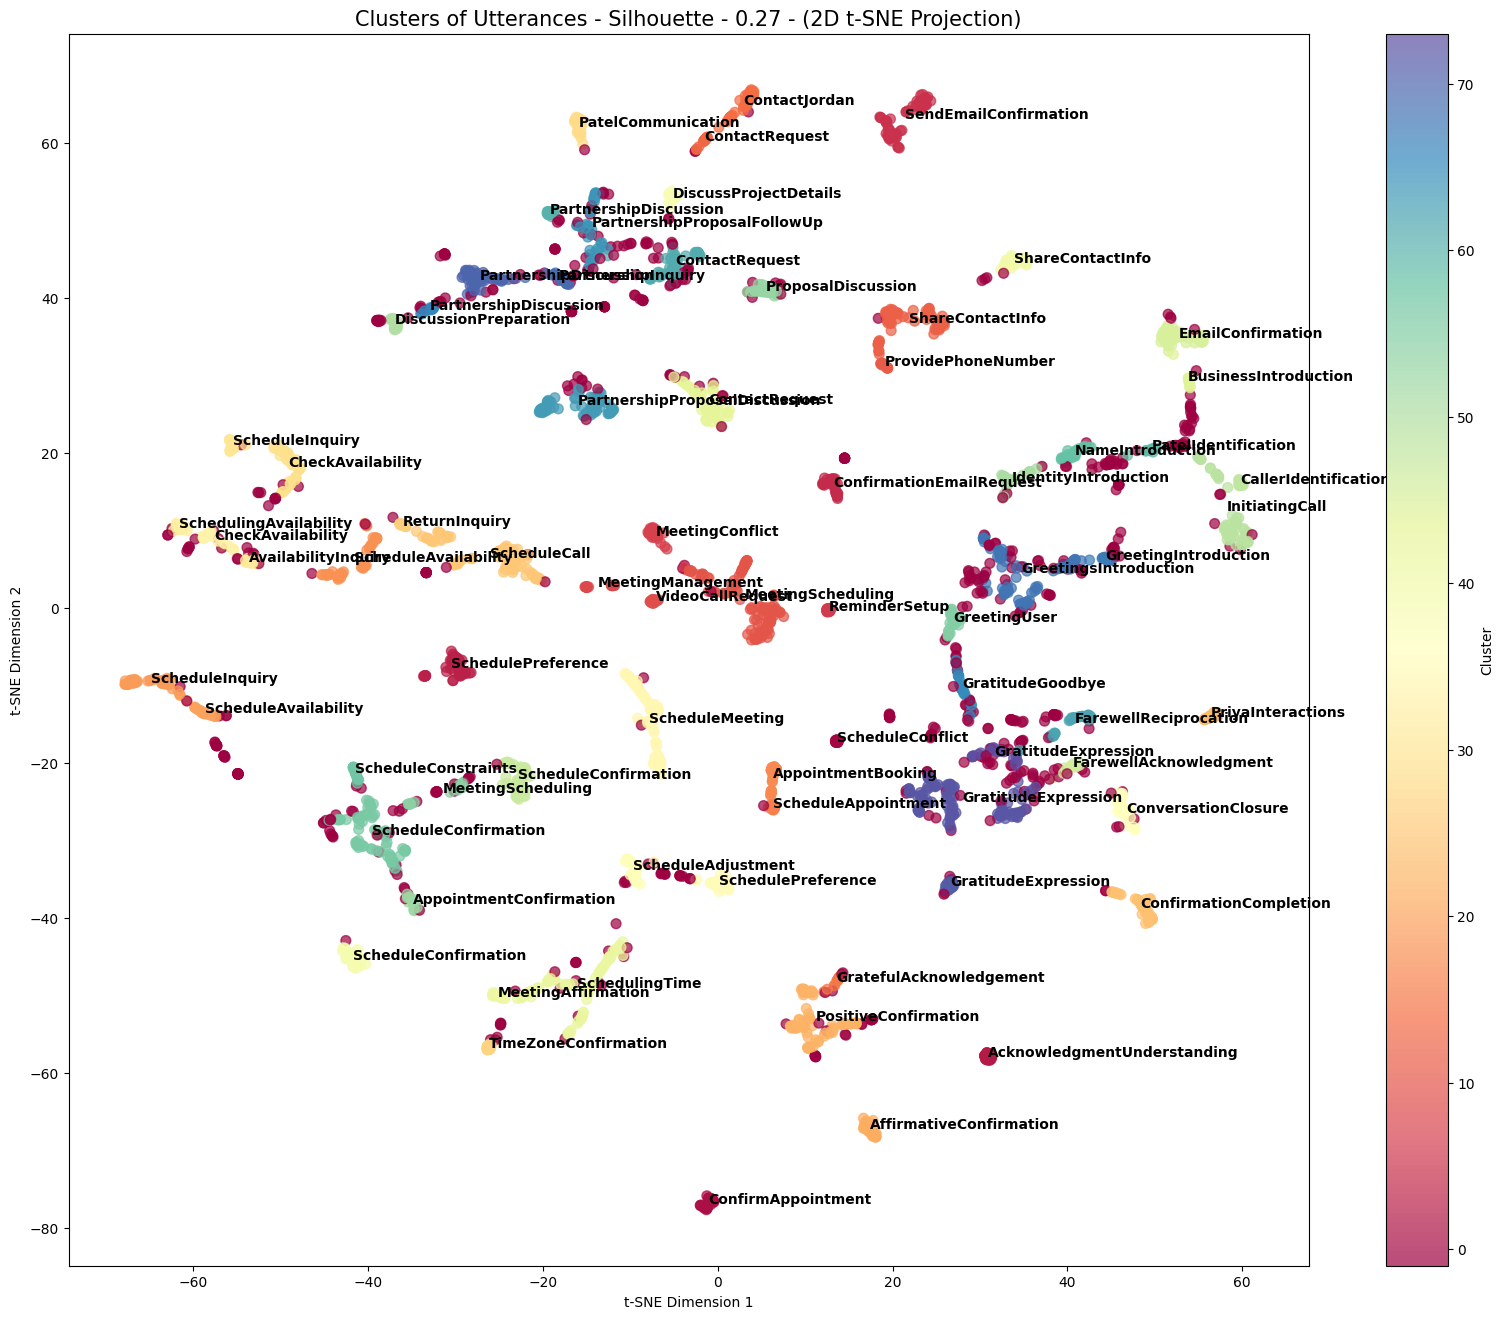

In [5]:
tss.cluster_and_name_utterances(
    workspace_dir=workspace.work_dir,
    utterances=user_utterances.unique_utterances,
    output_dir=workspace.intents_path,
    min_cluster_size=15,
)

Much like with the [getting started notebook](https://github.com/sitinc/journey-discovery-getting-started/blob/main/notes/journey-discovery-getting-started.ipynb), we can see the clusters are not ideal, and we can fine-tune components of the pipeline that produced this output, for the sake of this exercise, we'll move forward with clustering as it stands.  Fine-turning the cluster results (not the pipeline that led to the results) can be automated, semi-automated, or manual to varying degrees, now that you have an LLM prediction of what a cluster should be, you can inspect intents for utterances that align or don't align, and determine whether to update the cluster name/meaning and separate out any noise or utterances belonging to another identified cluster accordingly.  I will aim to semi-automate this process in future notebooks.  You can introduce additional dimensions like shared entity values or ranges to group things as you would prefer for your use cases.

## Extracting USER-only Entities

Let's extract entities for further inspection.

In [6]:
tss.extract_entities(user_df, workspace.entities_path)

'[########################################] 100.0% Extracting known entities'

## Visualizing Intents and Entity Distributions.

Alright, let's have a look at the clustered intents and recognized entities for the first run.

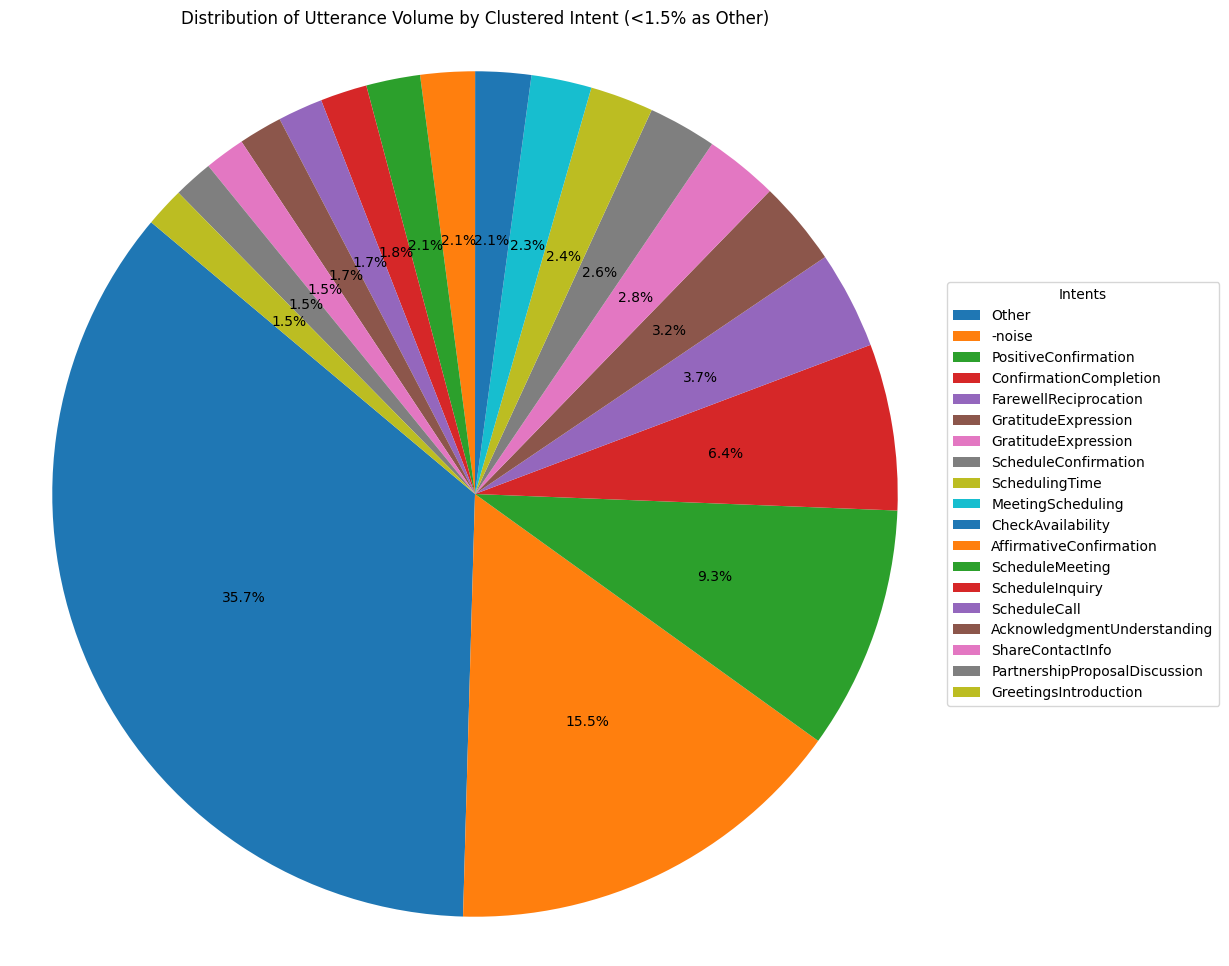

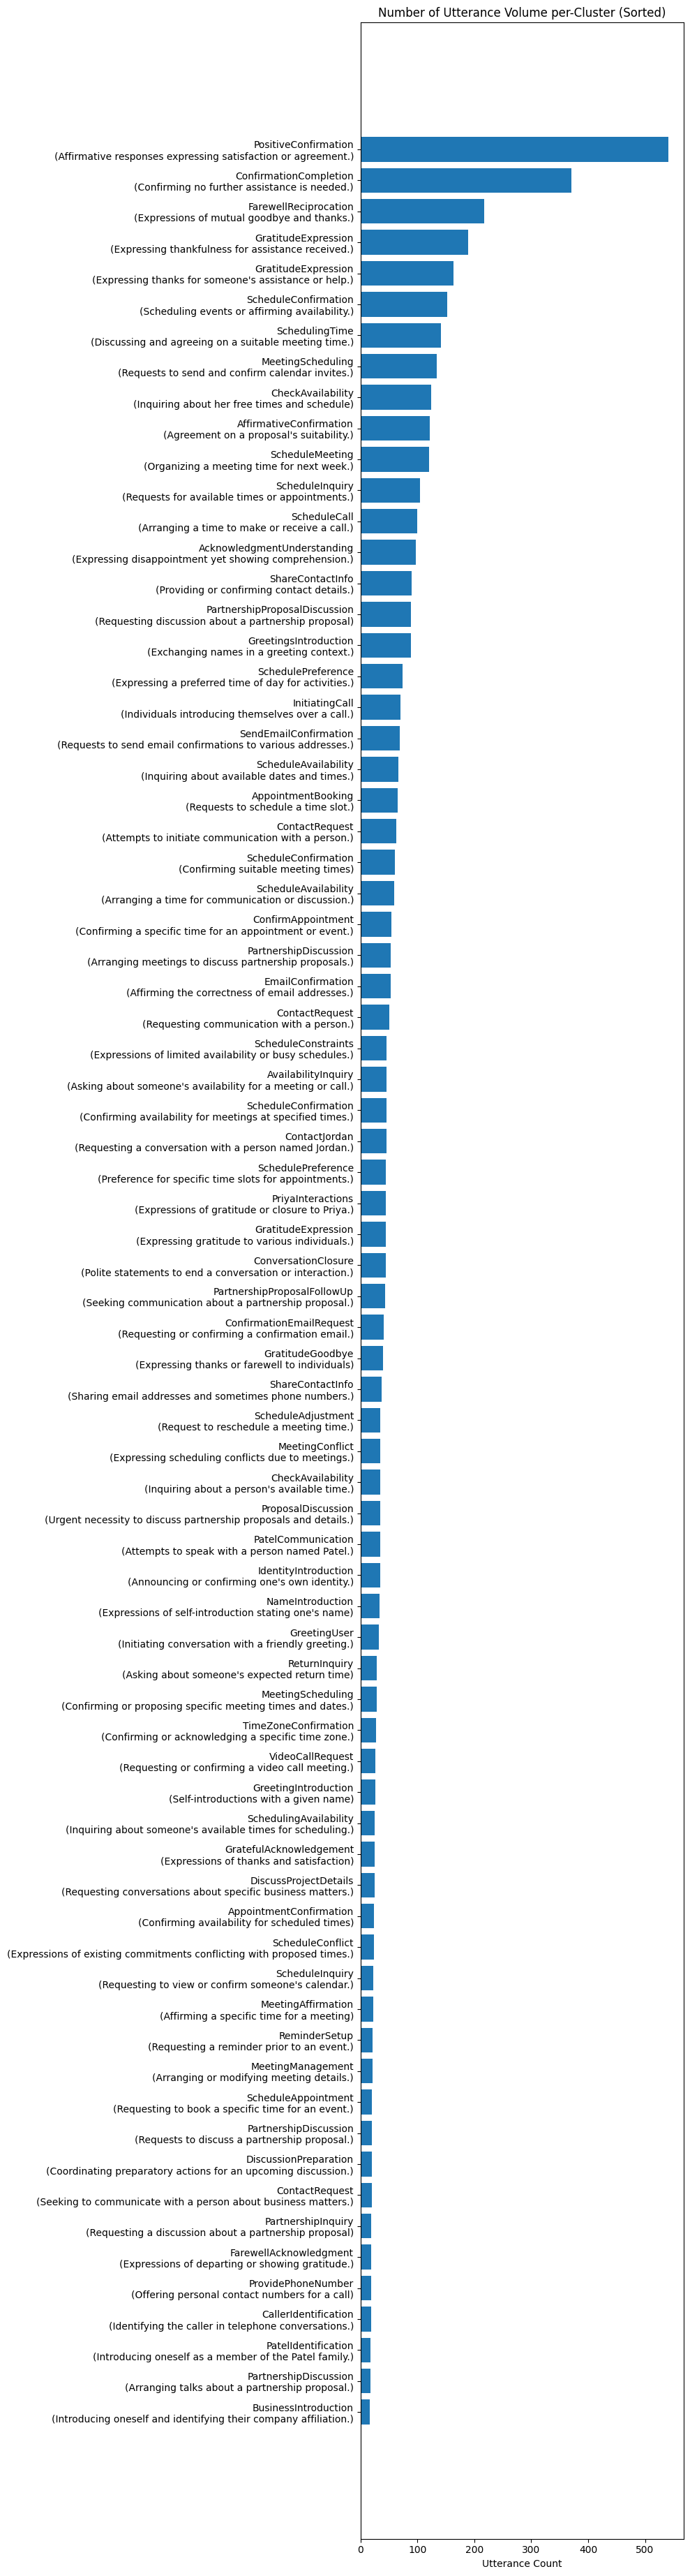

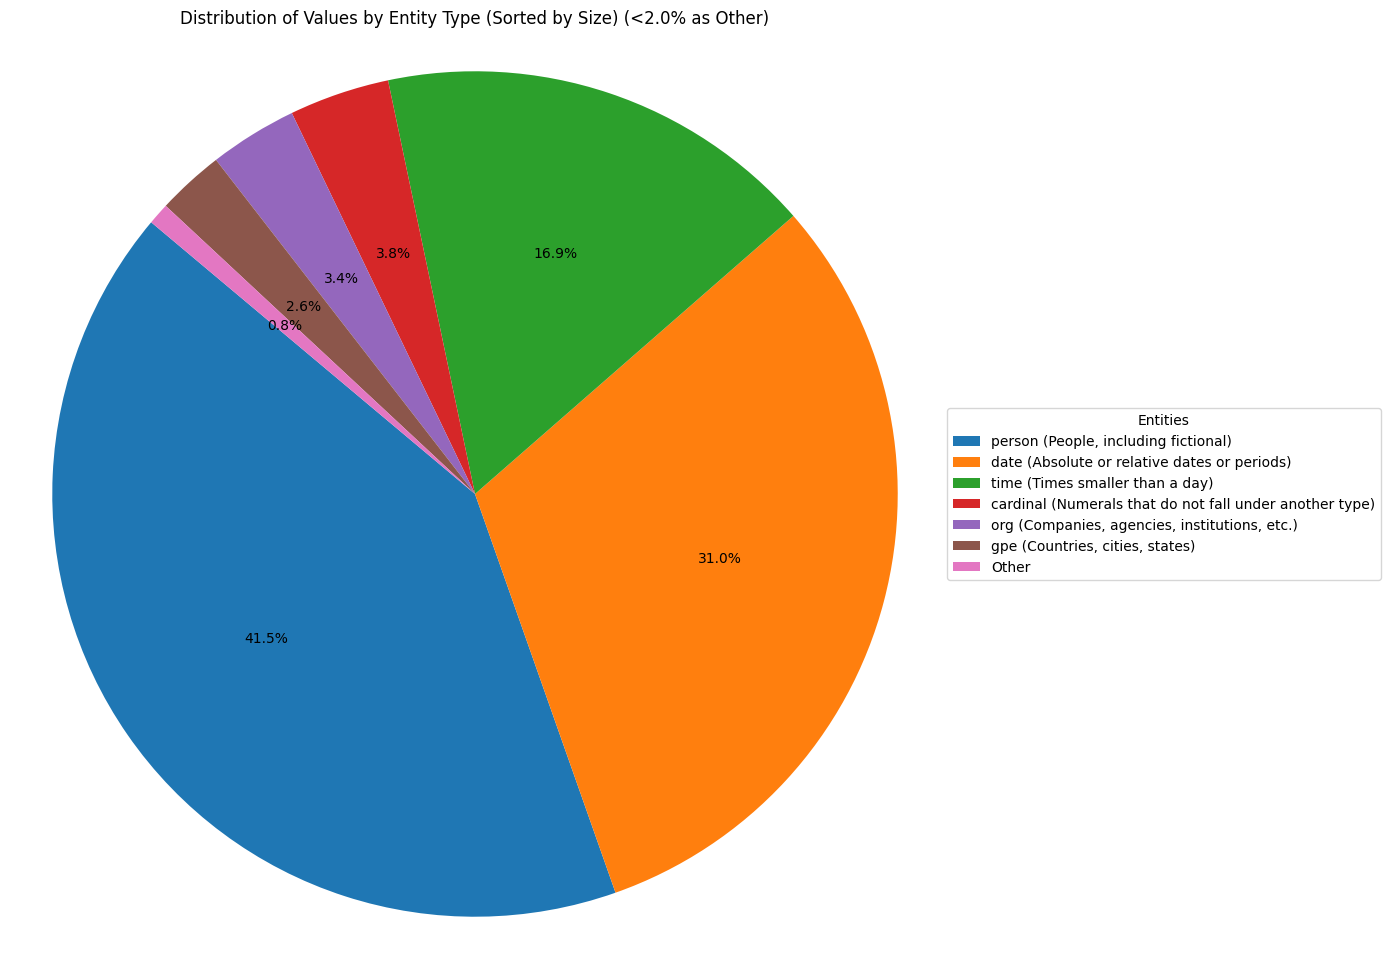

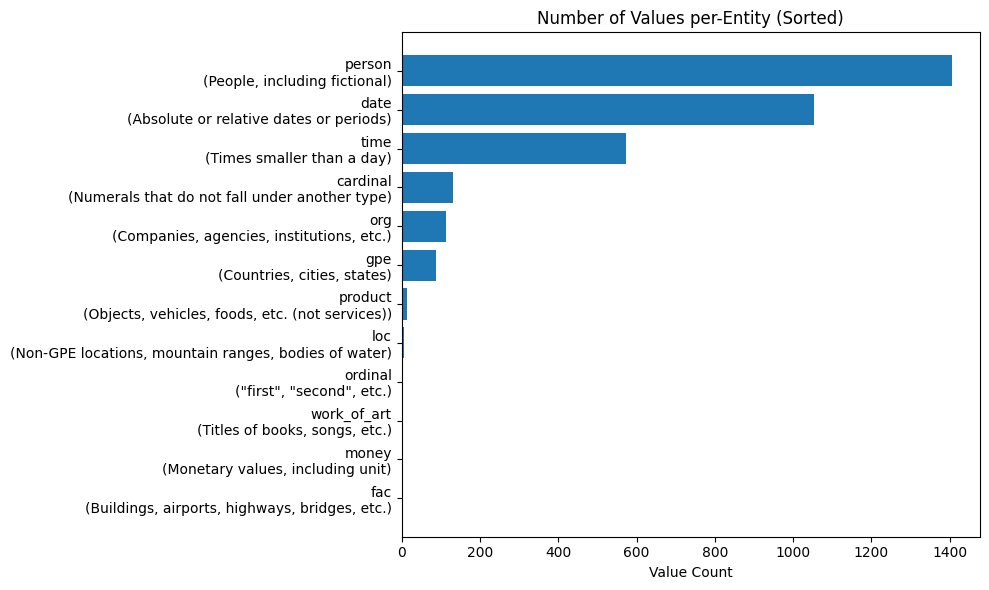

In [6]:
# Display Intent Distributions

# View pie chart distribution, including cluster noise.
intent_pie_chart = Transcripts.get_intent_utterance_counts(
    directory=workspace.intents_path,
    utterance_volumes=user_utterances.volume_utterance_count_map,
    incl_descr=False,
    incl_noise=True,
)
VizWrap.show_intent_pie(chart=intent_pie_chart,group_threshold=0.015)

# View horizontal bar chart of utterance volume.
intent_bar_chart = Transcripts.get_intent_utterance_counts(
    directory=workspace.intents_path,
    utterance_volumes=user_utterances.volume_utterance_count_map,
    incl_descr=True,
    incl_noise=False,
)
VizWrap.show_intent_bars(chart=intent_bar_chart)

# Display Entity Distributions

# View pie chart distribution
entity_pie_chart = Transcripts.get_entity_value_counts(
    directory=workspace.entities_path,
    incl_descr=True,
    descr_sep=' ',
)
VizWrap.show_entity_pie(chart=entity_pie_chart, group_threshold=0.02)

entity_bar_chart = Transcripts.get_entity_value_counts(
    directory=workspace.entities_path,
    incl_descr=True,
)
VizWrap.show_entity_bars(chart=entity_bar_chart)

## Grouping and Naming Higher-level Intent Groups

Now we'll add a step we did not execute in the getting-started notebook.  Let's group the newly clustered intents into higher level groups for easier inspection.

**Warning:**
DO NOT MODIFY/RUN this cell if you aren't 100% confident you understand the [financial outcome of the change/execution](https://openai.com/pricing).  Increasing the number of transcripts will linearly increase cost, while adding more instructions has a multiple effect on token usage for the total number of requested transcripts.

In [5]:
# Get the intent names.
intent_names = Transcripts.get_intent_names(workspace.intents_path, remove_dups=True)

# Generate the groupings.
intent_groupings = cluster_client.get_grouped_intent_names(
    intent_names=intent_names,
    output_dir=workspace.intent_groupings_path,
)

2024-01-09 13:09:04 - clusterLogger - INFO - b32d6f62-7867-4824-b5b9-ecf85e218197 | get_grouped_intent_names | Getting groups for Cluster Names
2024-01-09 13:09:23 - clusterLogger - INFO - b32d6f62-7867-4824-b5b9-ecf85e218197 | get_grouped_intent_names | result: {
  "Scheduling": [
    "ScheduleCall",
    "ScheduleAvailability",
    "ConfirmAppointment",
    "SchedulePreference",
    "CheckAvailability",
    "AppointmentBooking",
    "AvailabilityInquiry",
    "SchedulingTime",
    "ScheduleConflict",
    "ScheduleConstraints",
    "ScheduleAppointment",
    "SchedulingAvailability",
    "AppointmentConfirmation",
    "ScheduleAdjustment",
    "ScheduleMeeting",
    "ScheduleConfirmation",
    "MeetingScheduling",
    "SendEmailConfirmation",
    "ScheduleInquiry"
  ],
  "ContactInformation": [
    "ContactJordan",
    "ContactRequest",
    "VideoCallRequest",
    "ProvidePhoneNumber",
    "ShareContactInfo"
  ],
  "ProjectAndPartnership": [
    "DiscussProjectDetails",
    "Partnershi

## Checking the money Entity Type

Since we know we've introduced a scenario where some transcripts will now indicate there is a billing dispute over 5 or 7 dollars, let's check what we've identified as money entities so far.

In [26]:
ent_value_sources_path = os.path.join(workspace.entities_path, 'money', 'value_sources.csv')

ent_value_sources_df = pd.read_csv(ent_value_sources_path)
ent_value_counts = ent_value_sources_df.groupby('value').size()

print(ent_value_counts)

value
555-4289    1
dtype: int64


From the above we can see that 555-4289 is a phone number misclassified as money.  spaCy lacks a phone number entity by default, they can show up here, or more frequently in the "cardinal" entity type.  We can basically remove this entry from the file, at which point there are no recognized money entity values.

## Taking a Pause and Inspecting the Results

Alright.  Let's account for what we've just done.  I will write tools to better compare outputs between runs, but for now note down and inspect:

 - The generated intent names, distributions, and their groupings.
  - The generated intent meaning, in the readme.txt folder for each intent.
  - The entity values and their distribution.
  - The presence and/or distribution of money values.

You will be comparing these results with the same ones extracted from an augmented data set later in this notebook.

# Introducing Emergent Contact Drivers and Re-evaluating

Now that we've taken the time to inspect our "before" data, it's time to introduce new conversations by generating 5% of additional transcripts that cover a financial dispute over 5 or 7 dollars.  There will be a lot of overlap with the previous sections, but using a new workspace.  The goal and value comes from comparing the final outputs from the first major notebook section and this one.

## Creating another Workspace 

Let's create a new workspace for the augmented transcript analysis.

In [8]:
workspace_new = wm.create(name='test1-user-emergent')

## Copying over transcripts from prior Workspaces

We'll need to copy over the transcripts from the [getting started notebook](https://github.com/sitinc/journey-discovery-getting-started/blob/main/notes/journey-discovery-getting-started.ipynb) at this point, so make sure to complete it.

In [15]:
Utils.copy_dir(
    src_dir=workspace_old.transcripts_path,
    dst_dir=workspace_new.transcripts_path,
    incl_progress=True,
)

'[########################################] 100.0% Copying transcript files'

## Generating Emergent Contact Drivers Transcripts

Here we will leverage the OpenAI chat completions API to generate transcripts that will introduce a new emergent contact driver to see if we're able to pick it up.  The default model used is "gpt-4-1106-preview".  NOTE: This will incur usage-based-billing charges to your OpenAI API account.  You can change the model by adding the model="<model name>" to the gen_agent_transcripts function below.

**Warning:**
DO NOT MODIFY/RUN this cell if you aren't 100% confident you understand the [financial outcome of the change/execution](https://openai.com/pricing).  Increasing the number of transcripts will linearly increase cost, while adding more instructions has a multiple effect on token usage for the total number of requested transcripts.

The cell below will generate 5 transcripts for an executive assistant scheduling follow-up meetings.  The actual value used to generate the transcripts for the later cells (and for the blog entry relating to this notebook) was 25 (5% of 500).  The transcripts are generated using UTF-8 encoding, and includes characters that don't encode in ASCII.

In [16]:
user_prompt_gen_transcript = """The transcript should be of an executive assistant receiving calls for 
their executive and needing to schedule a follow-up at a later date.  Randomly decide on a date and time and how many 
turns it takes to book the appointment.  Randomly decide on people names, but make sure to use diverse names.  Don't 
use the words "my executive" or "your executive" or similar expressions.  Randomly decide on the reason the executive 
is unavailable.  Don't use an executive service as a business.  Make sure that in each case, the user calling the executive mentions that the executive ripped them off by $5 or $7 dollars.  Randomly decide between the two amounts each time."""

tss.gen_agent_transcripts(
    user_prompt=user_prompt_gen_transcript,
    quantity=25,
    output_dir=workspace_new.transcripts_path,
    offset=500,
)

'[########################################] 100.0% Generating transcripts'

## Assemble and Convert to CSV

Let's assemble all the transcripts to a CSV.

In [17]:
utterance_csv_file = tss.concat_and_process_ts_to_csv(
    in_dir=workspace_new.transcripts_path,
    out_dir=workspace_new.ts_combined_path,
)

print(f'Combined files into {utterance_csv_file}')

'[########################################] 100.0% Assembling transcripts to CSV file'

Combined files into C:\Local\Dev\Workspaces\SIT\journey-discovery-getting-started\notes\..\workspaces\test1-user-emergent\transcripts-combined\transcripts_combined.csv


# Loading the USER-only utterances, Part 2

Let's load the augmented utterances.

In [18]:
df_new = Transcripts.get_combined_utterances(in_dir=workspace_new.ts_combined_path)
user_df_new = df_new[df_new['participant'] != 'AGENT']
utterances_list_new = user_df_new['utterance'].tolist()

utterance_csv_path_new = os.path.join(workspace_new.ts_combined_path, 'transcripts_combined.csv')

user_utterances_new = Utterances(
    source=utterance_csv_path_new,
    utterances=utterances_list_new,
)

print(f"user_utterances: {user_utterances_new}")

user_utterances: Utterances(source=C:\Local\Dev\Workspaces\SIT\journey-discovery-getting-started\notes\..\workspaces\test1-user-emergent\transcripts-combined\transcripts_combined.csv, utterances=..., utterance_count=5989, unique_utterances=..., unique_utterance_count=3730, volume_utterance_count_map=...)


## Clustering USER-only Utterances, Part 2

Alright, now let's cluster our augmented utterances.

'[########################################] 100.0% Generating names for clusters'

2024-01-09 13:54:11 - transcriptLogger - INFO - c33dc0a9-7b3c-4d66-a0dc-d58e3cc7dd86 | cluster_and_name_utterances | Visualizing clusters


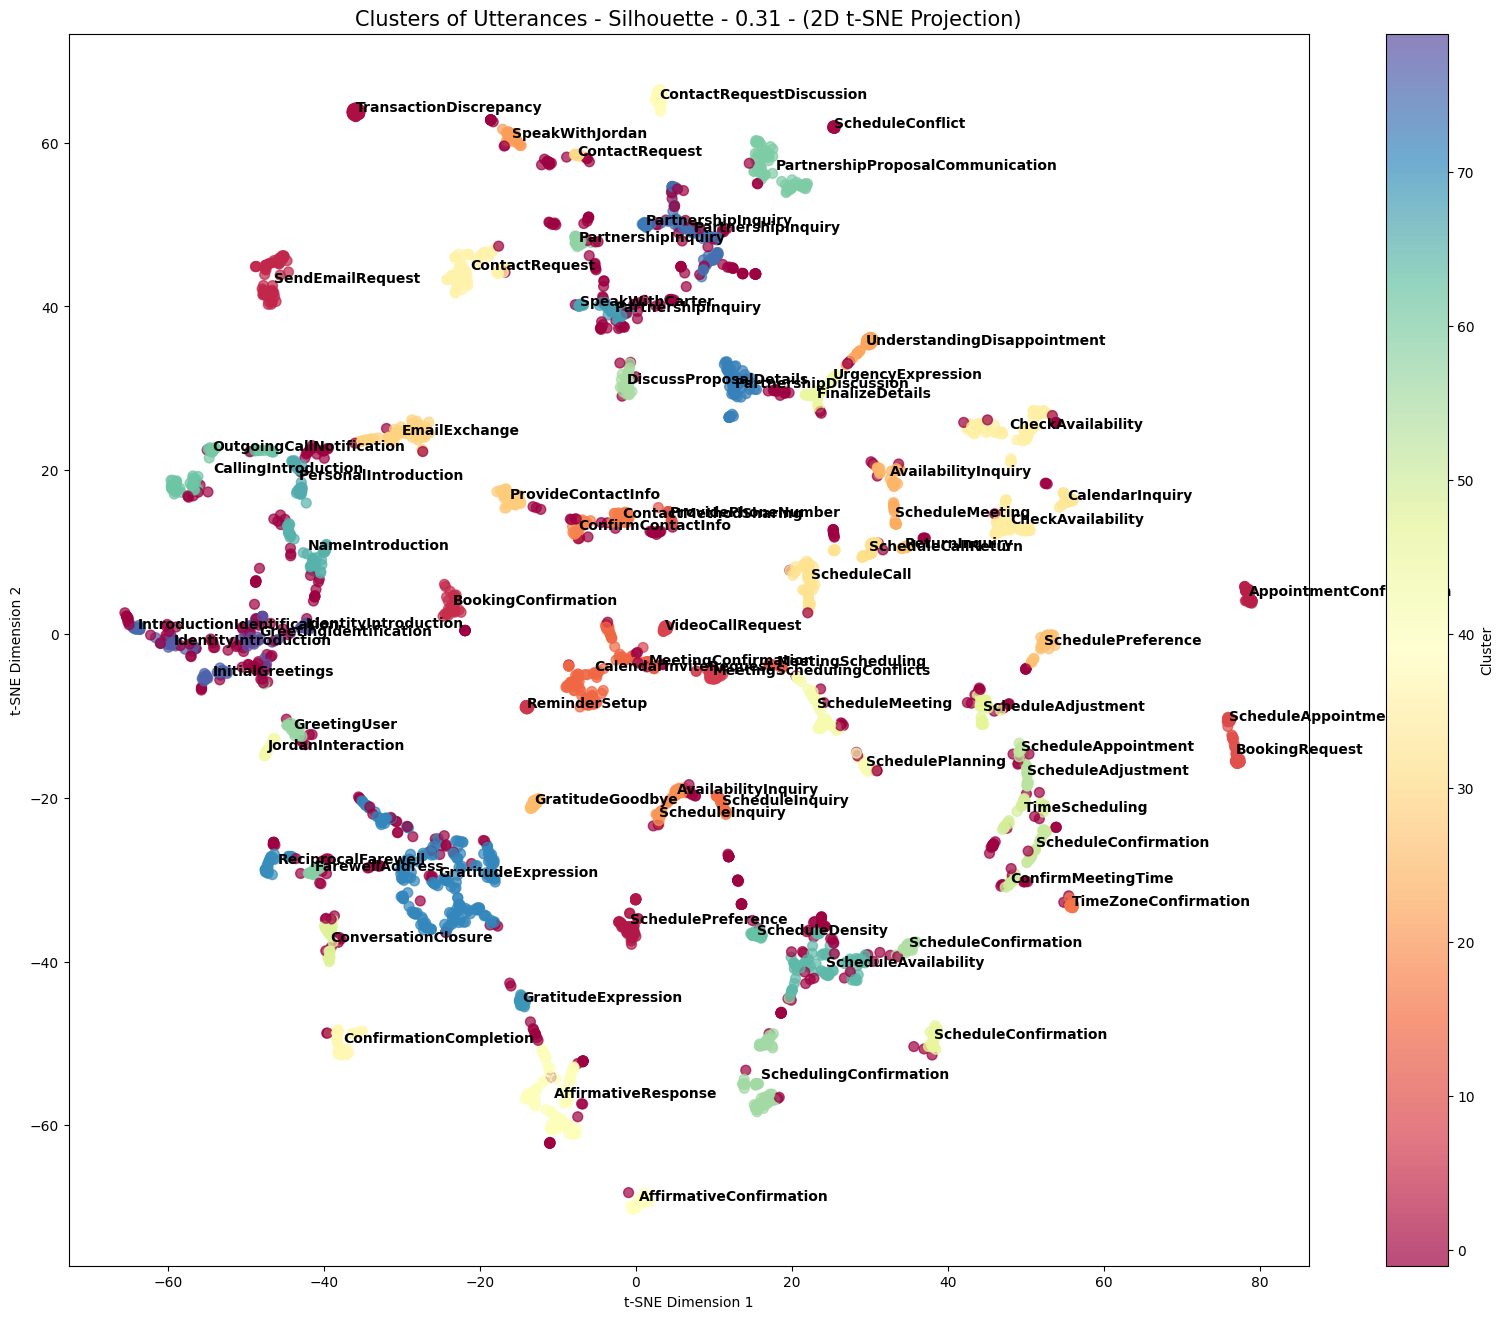

In [19]:
tss.cluster_and_name_utterances(
    workspace_dir=workspace_new.work_dir,
    utterances=user_utterances_new.unique_utterances,
    output_dir=workspace_new.intents_path,
    min_cluster_size=15,
)

## Extracting USER-only Entities, Part 2

Let's extract entities for the augmented transcripts for further inspection.

In [20]:
tss.extract_entities(user_df_new, workspace_new.entities_path)

'[########################################] 100.0% Extracting known entities'

## Visualizing Intents and Entity Distributions, Part 2

Let's have a look at the main distributions for intents and entities for the augmented transcripts.

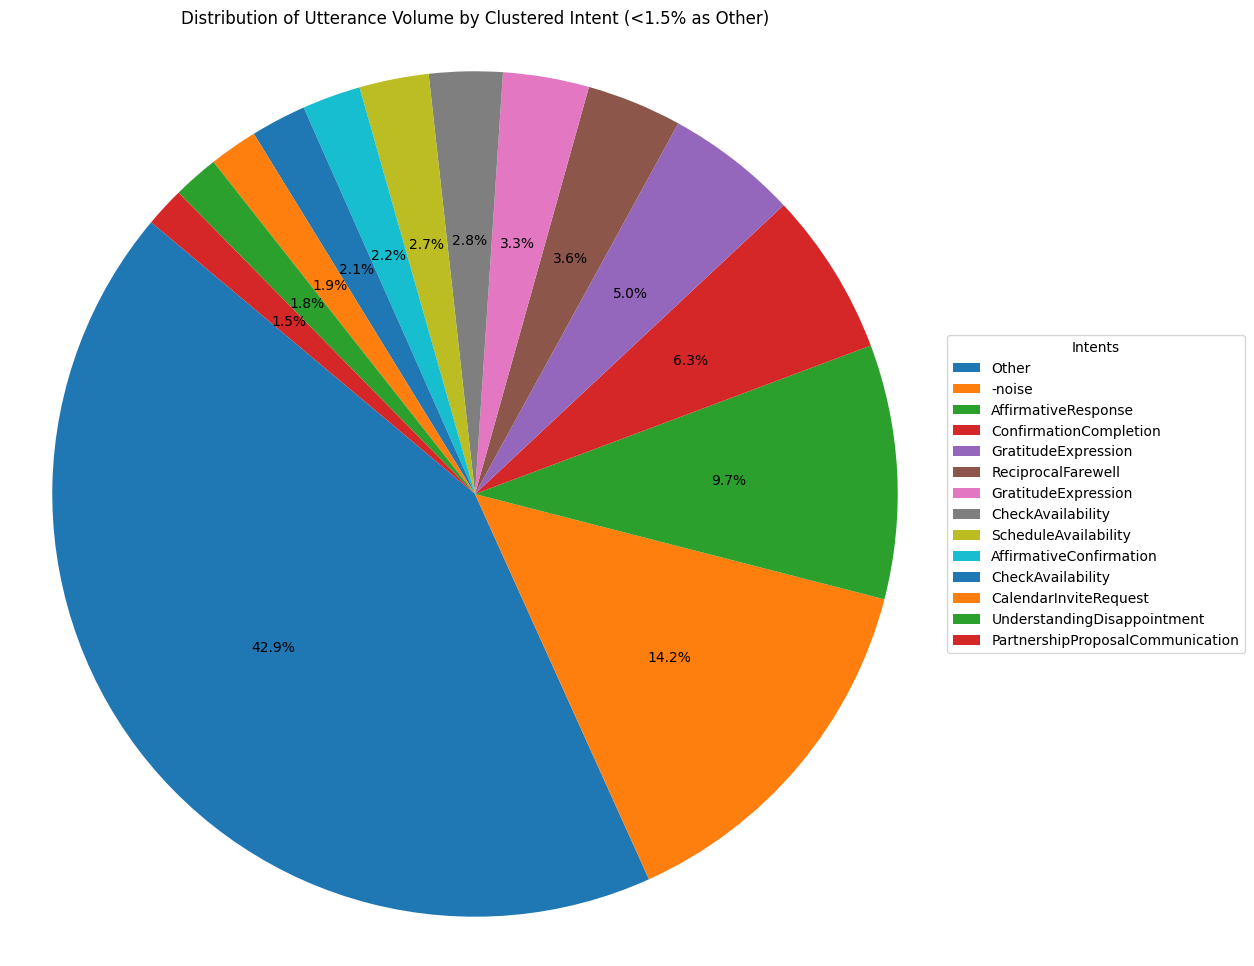

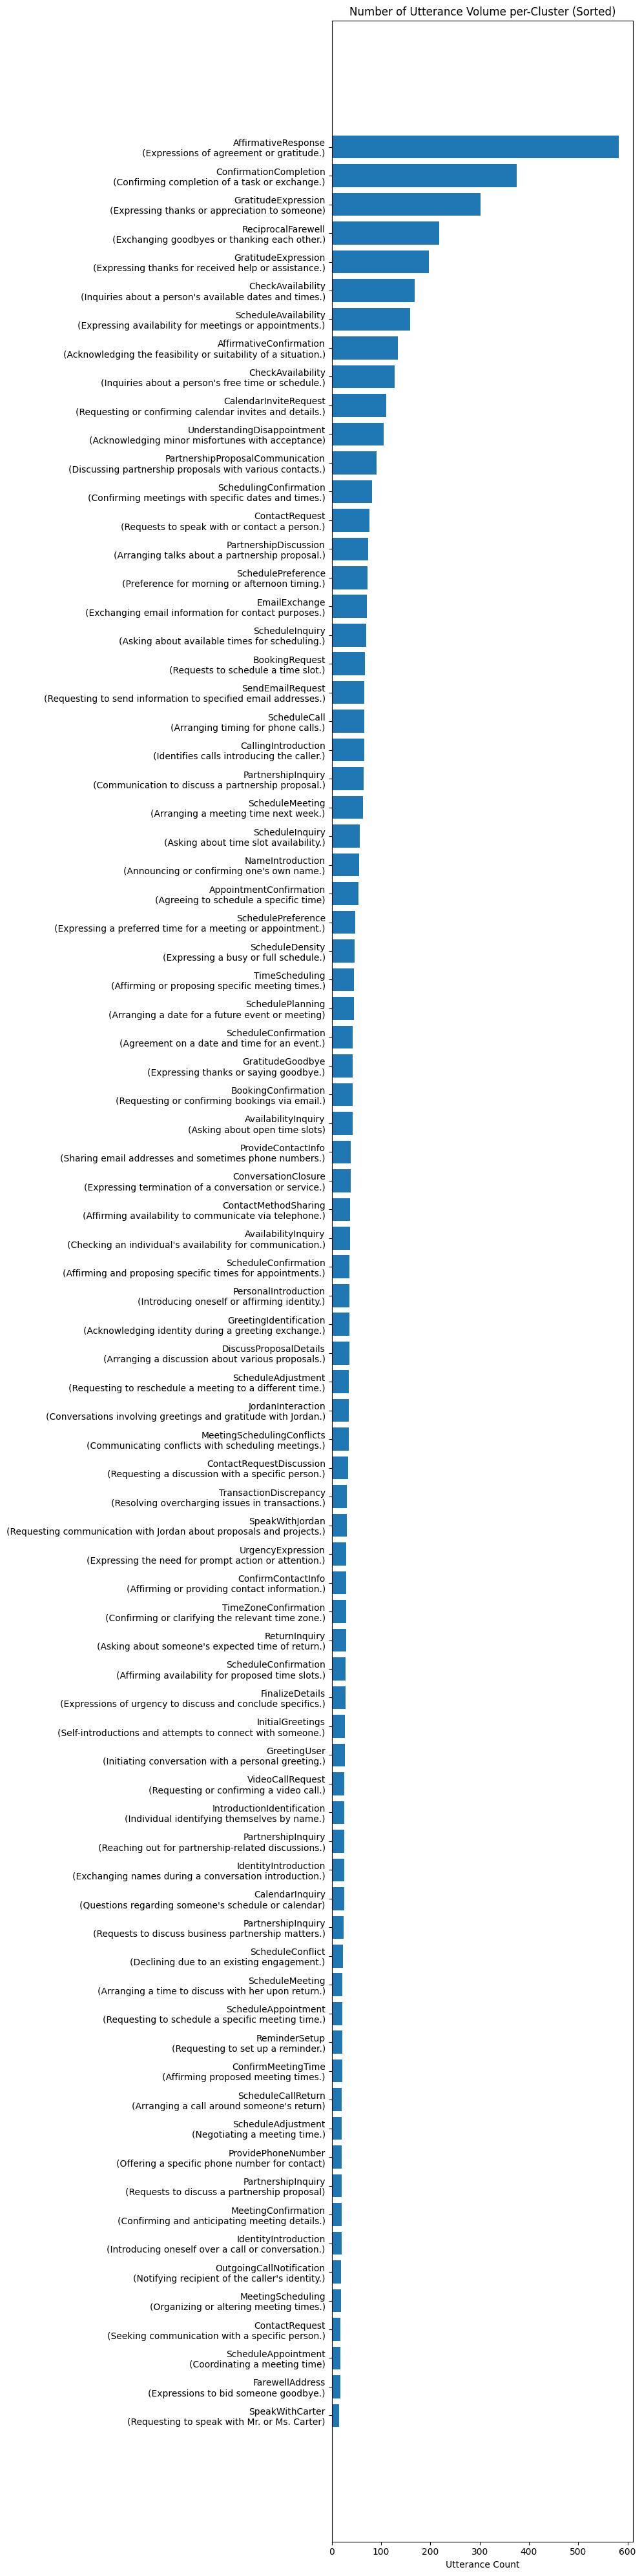

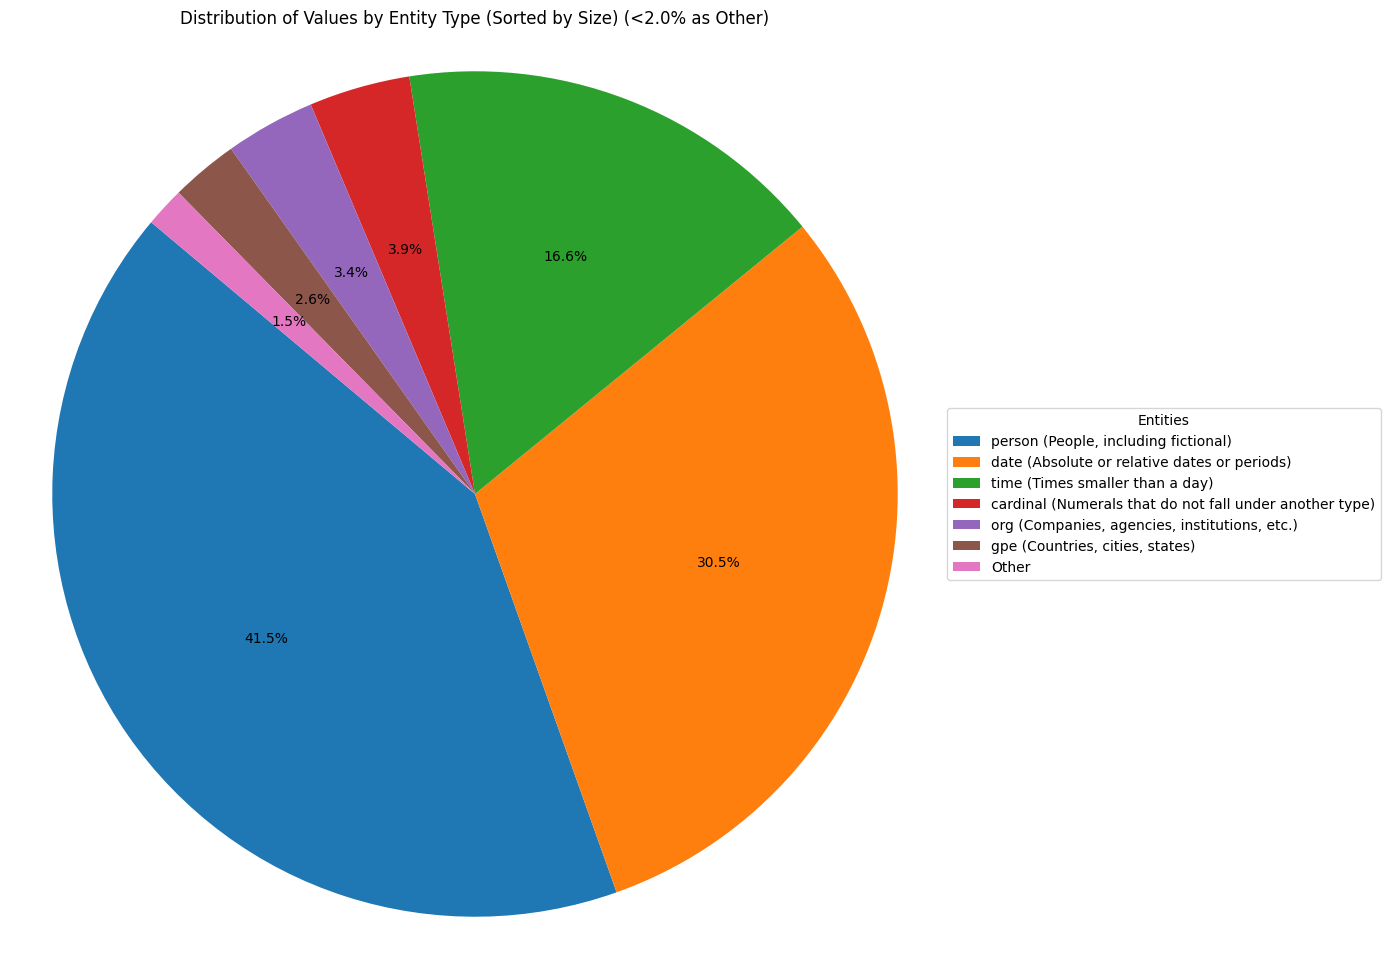

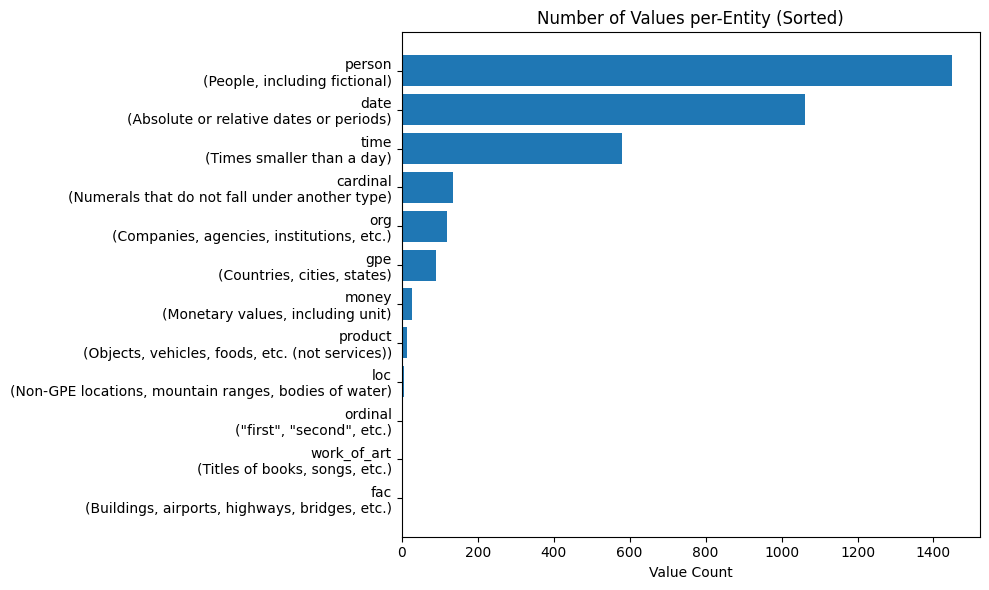

In [21]:
# Display Intent Distributions

# View pie chart distribution, including cluster noise.
intent_pie_chart_new = Transcripts.get_intent_utterance_counts(
    directory=workspace_new.intents_path,
    utterance_volumes=user_utterances_new.volume_utterance_count_map,
    incl_descr=False,
    incl_noise=True,
)
VizWrap.show_intent_pie(chart=intent_pie_chart_new,group_threshold=0.015)

# View horizontal bar chart of utterance volume.
intent_bar_chart_new = Transcripts.get_intent_utterance_counts(
    directory=workspace_new.intents_path,
    utterance_volumes=user_utterances_new.volume_utterance_count_map,
    incl_descr=True,
    incl_noise=False,
)
VizWrap.show_intent_bars(chart=intent_bar_chart_new)

# Display Entity Distributions

# View pie chart distribution
entity_pie_chart_new = Transcripts.get_entity_value_counts(
    directory=workspace_new.entities_path,
    incl_descr=True,
    descr_sep=' ',
)
VizWrap.show_entity_pie(chart=entity_pie_chart_new, group_threshold=0.02)

entity_bar_chart_new = Transcripts.get_entity_value_counts(
    directory=workspace_new.entities_path,
    incl_descr=True,
)
VizWrap.show_entity_bars(chart=entity_bar_chart_new)

## Grouping and Naming Higher-level Intent Groups, Part 2

Okay, final step of generating data for the augmented utterances.

**Warning:**
DO NOT MODIFY/RUN this cell if you aren't 100% confident you understand the [financial outcome of the change/execution](https://openai.com/pricing).  Increasing the number of transcripts will linearly increase cost, while adding more instructions has a multiple effect on token usage for the total number of requested transcripts.

In [22]:
# Get the intent names.
intent_names_new = Transcripts.get_intent_names(workspace_new.intents_path, remove_dups=True)

# Generate the groupings.
intent_groupings_new = cluster_client.get_grouped_intent_names(
    intent_names=intent_names_new,
    output_dir=workspace_new.intent_groupings_path,
)

2024-01-09 13:59:31 - clusterLogger - INFO - 2d6a379c-2b78-476f-b910-f51af0ae1e92 | get_grouped_intent_names | Getting groups for Cluster Names
2024-01-09 14:00:00 - clusterLogger - INFO - 2d6a379c-2b78-476f-b910-f51af0ae1e92 | get_grouped_intent_names | result: {
  "ContactInfo": [
    "ProvidePhoneNumber",
    "ContactRequest",
    "ConfirmContactInfo",
    "ProvideContactInfo",
    "ContactMethodSharing"
  ],
  "Greetings": [
    "GreetingUser",
    "InitialGreetings",
    "FarewellAddress",
    "GreetingIdentification",
    "ConversationClosure",
    "GratitudeGoodbye",
    "ReciprocalFarewell"
  ],
  "Identification": [
    "NameIntroduction",
    "IntroductionIdentification",
    "IdentityIntroduction",
    "PersonalIntroduction",
    "CallingIntroduction"
  ],
  "EmailCommunication": [
    "EmailExchange",
    "SendEmailRequest"
  ],
  "ScheduleManagement": [
    "ScheduleCall",
    "BookingConfirmation",
    "ScheduleAvailability",
    "SchedulePreference",
    "CalendarInviteR

So basically, the only money entity identified at this point is a phone number misclassified as a money amount, likely a range.

## Checking the money Entity Type, Part 2

Now let's check the value distributions for the money entity again.

In [27]:
ent_value_sources_path_new = os.path.join(workspace_new.entities_path, 'money', 'value_sources.csv')

ent_value_sources_df_new = pd.read_csv(ent_value_sources_path_new)
ent_value_counts_new = ent_value_sources_df_new.groupby('value').size()

print(ent_value_counts_new)

value
5           22
555-4289     1
7            3
dtype: int64


## Taking a Pause and Inspecting the Results

As mentioned earlier, I will write tools to better compare outputs between runs.  After inspecting the below by hand, our new and emergent intent was discovered.

 - The generated intent names, distributions, and their groupings.
  - The generated intent meaning, in the readme.txt folder for each intent.
  - The entity values and their distribution.
  - The presence and/or distribution of money values.

In this particular run, the intent was named "1_TransactionDiscrepancy", but running this again could produce an entirely different name.  Even if you followed the steps identically, your intent name is likely to be different also.  The main idea is to dedup and group intents as a means of catching more obvious.  This step can be improved significantly by predefining expected intents and trying to add some form of determinism in the grouping process.  Let's have a look at a few lines from the "1_TransactionDiscrepancy" intent.


From 1_TransactionDiscrepancy:
 - I noticed that my last transaction with Adrian had an overcharge of 5.
  - I noticed Mr. Thompson overcharged me by 5 on our last transaction.
  - There's been a minor discrepancy in our last transaction; he shortchanged me by 5.
  - I was just looking over my receipt and I noticed that I was overcharged.
  - I just noticed that there's a 5 overcharge on our last transaction.


It seems there is a pattern in the amount here (we know there is based on the prompt we use to generate the data).  After looking at the money entity we now see 22 occurrences of 5 dollars and 3 occurrences of 7 dollars.  Opening the 'value_source.csv' will give you the source transcript file name reference which you can use to search and open the transcript and review the conversation for qualitative analysis.

# Conclusion

I hope this has been very helpful in the types of semi-automated things you can do to better understand interactional data.  

With this, we've collected data for what people are saying and dig into some of the common important types of things people talk about in our generated use case.

I will continue to expand and improve this notebook and the associated project to help those that benefit from its use.  I apologize in advance that at this early stage there will be breaking changes in the future, but it will all be in the name of making things more effortless for all.

Now let's get back to the blog post to for closing thoughts.